In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

import importlib
import warnings
import pickle
import os

import sys
sys.path.append('/accounts/grad/jeremy_goldwasser/Counterfactuals/cf_stylegan_celeba')
from SimpleCNNarchitecture import SimpleCNN


## Load data

In [20]:
celebaDir = "/accounts/grad/jeremy_goldwasser/Counterfactuals/celeba/"
imDir = celebaDir + 'img_align_celeba/'

### Load attributes

In [21]:
# Load labels. image_id is aligned with img_align_celeba/, but not ""_stylegan/
import pandas as pd
attr = pd.read_csv(celebaDir+'list_attr_celeba.txt', sep='\s+', header=1)
attr.head()



,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
print(np.mean(attr['Young']==1))
print(np.mean(attr['Male']==1))
print(np.mean(attr['Attractive']==1))
print(np.mean(attr['Smiling']==1))


0.773616849046639
0.41675427815537097
0.51250499755675
0.48208036564839907


### Make dataset

In [5]:

from PIL import Image

class ImageDatasetWithLabels(Dataset):
    def __init__(self, directory, label_frame, label_column, transform=None):
        """
        Initializes the dataset.
        :param directory: Path to the directory containing images.
        :param label_frame: A pandas DataFrame containing the labels.
        :param label_column: The column in label_frame that contains the labels.
        :param transform: Transformations to be applied to the images.
        """
        self.image_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')])
        # Assumes index alignment with image files
        self.labels = label_frame[label_column].values==1
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load label
        label = self.labels[idx]
        
        return image, label

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop((178, 178)),
    torchvision.transforms.Resize((256, 256))
])

# Label = 'Young'
# Label = 'Male'
# Label = 'Smiling'
Label = 'Attractive'
dataset = ImageDatasetWithLabels(imDir, attr, Label, transform=transform)
print(len(dataset)==attr.shape[0])

True


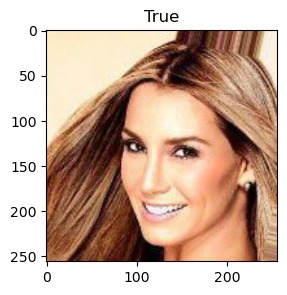

In [6]:
im_idx = 0
plt.figure(figsize=(3,3)); plt.imshow(dataset[im_idx][0].permute(1,2,0)); plt.title(dataset[im_idx][1]); plt.show()

## Make train/test split and align all labels

In [7]:
# Split dataset 80-20 into train and test
torch.manual_seed(1)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Will use for scoring counterfactuals, potentially
attr_train = attr.iloc[train_dataset.indices]
attr_test = attr.iloc[test_dataset.indices]
attr_test.head() 

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
179293.jpg,-1,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,-1,-1,1,-1,-1,-1
136581.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,1,-1,1,1,-1,1
008116.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1
025830.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
173343.jpg,-1,1,1,-1,-1,-1,1,-1,-1,1,...,-1,1,-1,-1,1,-1,1,-1,-1,1


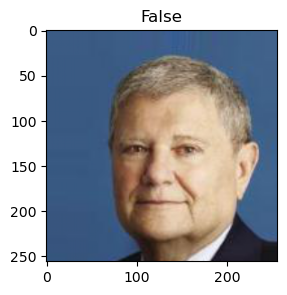

In [8]:
im_idx = 4
plt.figure(figsize=(3,3)); plt.imshow(train_dataset[im_idx][0].permute(1,2,0)); plt.title(train_dataset[im_idx][1]); plt.show()

# Train net

In [9]:
# Initialize model, loss, and optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()  # binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda:0


In [10]:
num_epochs = 5
print_interval = 250 # 100
model.train()

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    running_loss = 0.0
    total_correct = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        total_correct += torch.sum(preds == labels)

        # Print update every `print_interval` batches
        if (batch_idx + 1) % print_interval == 0:
            # current_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            # current_acc = total_correct.double() / ((batch_idx + 1) * train_loader.batch_size)
            current_loss = loss.item()
            current_acc = torch.sum(preds==labels).item()/len(preds)
            # print(outputs[:5])
            print(f'Batch {batch_idx + 1}/{len(train_loader)} - Loss: {current_loss:.4f}, Accuracy: {current_acc:.4f}')

            # if current_acc > 0.95:
            #     break
    
# Evaluate on test set after each epoch
# test_loss, test_acc = evaluate(model, test_loader, criterion, device)

Epoch 1/5
Batch 250/5065 - Loss: 0.4983, Accuracy: 0.8125
Batch 1000/5065 - Loss: 0.5227, Accuracy: 0.7500
Batch 1250/5065 - Loss: 0.3916, Accuracy: 0.8438
Batch 1500/5065 - Loss: 0.6934, Accuracy: 0.6875
Batch 1750/5065 - Loss: 0.5126, Accuracy: 0.7500
Batch 2000/5065 - Loss: 0.5727, Accuracy: 0.6875
Batch 2250/5065 - Loss: 0.5408, Accuracy: 0.6875
Batch 2500/5065 - Loss: 0.4216, Accuracy: 0.8438
Batch 2750/5065 - Loss: 0.4183, Accuracy: 0.8438
Batch 3000/5065 - Loss: 0.4468, Accuracy: 0.7500
Batch 3250/5065 - Loss: 0.4499, Accuracy: 0.7500
Batch 3500/5065 - Loss: 0.4106, Accuracy: 0.8438
Batch 3750/5065 - Loss: 0.4958, Accuracy: 0.7500
Batch 4000/5065 - Loss: 0.3932, Accuracy: 0.8438
Batch 4250/5065 - Loss: 0.6020, Accuracy: 0.7188
Batch 4500/5065 - Loss: 0.3961, Accuracy: 0.7812
Batch 4750/5065 - Loss: 0.5174, Accuracy: 0.7188
Batch 5000/5065 - Loss: 0.5039, Accuracy: 0.7500
Epoch 2/5
Batch 250/5065 - Loss: 0.2524, Accuracy: 0.8438
Batch 500/5065 - Loss: 0.5753, Accuracy: 0.7812
Bat

In [17]:
predictorDir = celebaDir + 'predictors/'
fname = Label.lower() + '_weights.pt'
weights_path = predictorDir + fname
weights_path

'/accounts/grad/jeremy_goldwasser/Counterfactuals/celeba/predictors/attractive_weights.pt'

In [18]:
torch.save(model.state_dict(), weights_path)

# Evaluate model

In [13]:
# weights_path = predictorDir + 'young_weights_v2.pt'
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [14]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reshape labels to be compatible with model outputs
            labels = labels.float().unsqueeze(1)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            total_correct += torch.sum(preds == labels)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = total_correct.double() / len(test_loader.dataset)
    
    print(f'Test Loss: {epoch_loss:.4f}, Test Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [16]:
# Create a new test DataLoader with less data
subset_size = 1000
test_data_subset = Subset(test_loader.dataset, list(range(subset_size)))
test_loader_subset = DataLoader(test_data_subset, batch_size=test_loader.batch_size, shuffle=False)

# Evaluate after training
_ = evaluate(model, test_loader_subset, criterion, device)

Test Loss: 0.6168, Test Acc: 0.7840


In [48]:
# Confirmed this works!
subset_fnames = np.array(dataset.image_files)[test_dataset.indices]
# print(subset_fnames[0].split('/')[-1])
# display(Image.open(subset_fnames[1]))
# to_pil = transforms.ToPILImage()
# for inputs, labels in test_loader_subset:
#     display(to_pil(inputs[1].cpu()))
#     break

Found a mismatch: True label = 1.0, Predicted label = False


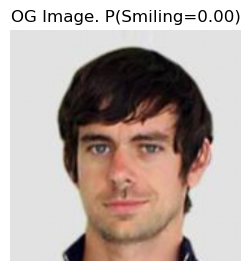

In [51]:
model.eval()
num_batches = 0
failure_idx = 4
wrong_prediction_sample = None
with torch.no_grad():  # No need to track gradients for evaluation
    for inputs, labels in test_loader_subset: # Goes through one batch at a time
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) >= 0.5
        
        # Find indices where predictions are not equal to labels
        mismatches = (preds != labels)
        if mismatches.any() and mismatches.sum()>failure_idx:
            wrong_idx = mismatches.nonzero(as_tuple=True)[0][failure_idx].item()  # Get the index of the first mismatch
            wrong_prediction_sample = (inputs[wrong_idx], labels[wrong_idx], preds[wrong_idx])
            idx = batch_size*num_batches + wrong_idx
            break
        else:
            num_batches += 1

if wrong_prediction_sample:
    input_image, true_label, predicted_label = wrong_prediction_sample
    print(f"Found a mismatch: True label = {true_label.item()}, Predicted label = {predicted_label.item()}")
    pred = torch.sigmoid(model(input_image)).item()
    plt.figure(figsize=(3,3)); plt.imshow(input_image.cpu().permute(1,2,0)); 
    plt.title(f'OG Image. P({Label}={pred:.2f})')
    # plt.title('Original Image')
    plt.axis('off'); plt.show()
else:
    print("No wrong predictions found in the test subset.")

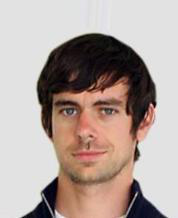

In [52]:
display(Image.open(subset_fnames[idx])) # yep

In [58]:
fname = subset_fnames[idx]
num_fname = fname.split('/')[-1].split('.')[0]

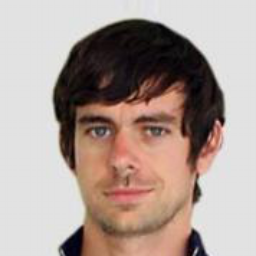

In [59]:
tensor = (input_image).cpu()

to_pil = transforms.ToPILImage()
image = to_pil(tensor)
saved_im_dir = os.path.join(celebaDir, 'sample_images', Label.lower())
os.makedirs(saved_im_dir, exist_ok=True)
image.save(os.path.join(saved_im_dir, 'failure_ex_' + num_fname + '.png'))
image

In [60]:
# image2 = Image.open(os.path.join(celebaDir, 'sample_images', 'gender', 'failure_ex.png'))
# image2